
# ExecutionTask — Basics

This notebook gives a compact, **teaching-style** walkthrough of the `ExecutionTask`:

- define simple generators (value streams),
- define simple agents that output non-negative consumption vectors,
- run the task and inspect logs,
- plot remaining resource and cumulative cost.

> Domain-agnostic: generators emit numeric values over time; the agent decides how much of a scalar resource to consume each step across K streams. Cost is based on value *differences* and a remaining-resource penalty.


In [1]:

# Imports
import numpy as np
import matplotlib.pyplot as plt

# Import from your package (ensure tsdm is installed or on PYTHONPATH)
from tsdm.tasks import ExecutionTask



## 1) Tiny demo components

Generators (value streams):
- `UpGen`: increases by +1 each step.
- `FlatGen`: stays constant.
- `ConstGen`: returns a constant value.

Agents (consumption policies):
- `FractionExecutorAgent`: consumes a fixed fraction of remaining resource each step, split evenly across K streams.
- `AllAtOnceWrapper`: consumes the entire remaining resource at once (evenly across K) to illustrate early stopping.


In [2]:

class UpGen:
    """Monotone increasing generator: v_t = v_{t-1} + 1"""
    def generate_value(self, last):
        return (0.0 if last is None else last) + 1.0

class FlatGen:
    """Constant generator: v_t = v_{t-1}"""
    def generate_value(self, last):
        return (0.0 if last is None else last)

class ConstGen:
    """Generator that always returns a fixed scalar (ignores `last`)."""
    def __init__(self, value): self.value = float(value)
    def generate_value(self, last): return self.value


class FractionExecutorAgent:
    """Consumes a fixed fraction of remaining resource each step, split evenly over K streams."""
    def __init__(self, fraction: float, k: int):
        self.fraction = float(fraction)
        self.k = int(k)
        self.observed = []
    def observe(self, state):
        # state: { values, remaining_inventory, remaining_time, cost_cum }
        self.observed.append(state)
    def place_bet(self):
        remaining = self.observed[-1]["remaining_inventory"]
        per = (self.fraction * remaining) / self.k if self.k > 0 else 0.0
        return np.full(self.k, per, dtype=float)


class AllAtOnceAgent:
    """Consumes the entire remaining resource at once, split evenly across K."""
    def __init__(self, k: int):
        self.k = int(k)
        self._remain = None
    def observe(self, state):
        self._remain = state["remaining_inventory"]
    def place_bet(self):
        # Even split of full remaining
        per = (self._remain / self.k) if self.k > 0 else 0.0
        return np.full(self.k, per, dtype=float)



## 2) Run: Two rising streams + FractionExecutorAgent

Cost per step (no impact, no benchmark):
```
step_cost = dot(values_t - values_{t-1}, x_t) + kappa * (remaining_before)^2
```
We use:
- `K = 2` streams, both increasing by +1 each step,
- start values `[10, 10]`,
- initial resource `Q = 1.0`,
- fraction agent with `fraction = 0.4`,
- `kappa = 0.0` (no remaining-resource penalty).


In [4]:

K = 2
gens = [UpGen(), UpGen()]
start_vals = np.array([10.0, 10.0], dtype=float)
agent = FractionExecutorAgent(fraction=0.4, k=K)

task = ExecutionTask(
    generators=gens,
    agent=agent,
    total_movements=10,
    start_values=start_vals,
    initial_inventory=1.0,  # total resource
)
reward = task.play_game()
total_cost = -reward  # task returns negative cost as reward

print(f"Total cost: {total_cost:.6f}")
print(f"Steps executed: {len(task.log)}")
print("First 3 logs:")
for rec in task.log:
    print({k: rec[k] for k in ["t", "values_prev", "values", "x", "q_remaining", "step_cost", "cost_cum"]})


Total cost: 12.484883
Steps executed: 10
First 3 logs:
{'t': 1, 'values_prev': array([10., 10.]), 'values': array([11., 11.]), 'x': array([0.2, 0.2]), 'q_remaining': 0.6, 'step_cost': 4.4, 'cost_cum': 4.4}
{'t': 2, 'values_prev': array([11., 11.]), 'values': array([12., 12.]), 'x': array([0.12, 0.12]), 'q_remaining': 0.36, 'step_cost': 2.88, 'cost_cum': 7.28}
{'t': 3, 'values_prev': array([12., 12.]), 'values': array([13., 13.]), 'x': array([0.072, 0.072]), 'q_remaining': 0.216, 'step_cost': 1.8719999999999999, 'cost_cum': 9.152000000000001}
{'t': 4, 'values_prev': array([13., 13.]), 'values': array([14., 14.]), 'x': array([0.0432, 0.0432]), 'q_remaining': 0.1296, 'step_cost': 1.2096, 'cost_cum': 10.361600000000001}
{'t': 5, 'values_prev': array([14., 14.]), 'values': array([15., 15.]), 'x': array([0.02592, 0.02592]), 'q_remaining': 0.07776, 'step_cost': 0.7776, 'cost_cum': 11.1392}
{'t': 6, 'values_prev': array([15., 15.]), 'values': array([16., 16.]), 'x': array([0.015552, 0.015552])


### Plot: remaining resource and cumulative cost


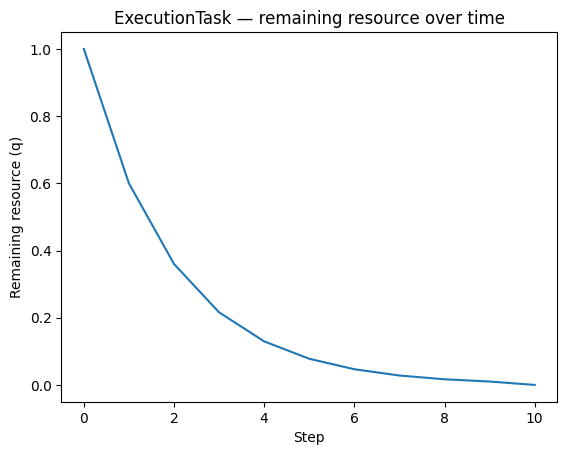

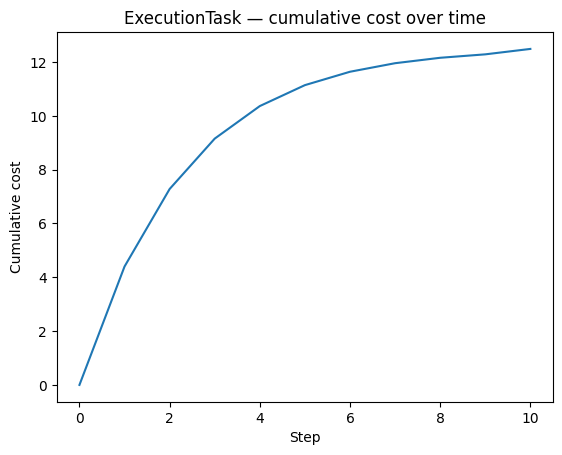

In [6]:

plt.figure()
plt.plot(task.inventory_development)
plt.xlabel("Step")
plt.ylabel("Remaining resource (q)")
plt.title("ExecutionTask — remaining resource over time")
plt.show()

plt.figure()
plt.plot(task.cost_development)
plt.xlabel("Step")
plt.ylabel("Cumulative cost")
plt.title("ExecutionTask — cumulative cost over time")
plt.show()



## 3) Early stopping: AllAtOnceAgent

Shows that the task stops early when the resource is fully consumed in the first step.


In [8]:

K = 3
gens2 = [ConstGen(1.0) for _ in range(K)]
start_vals2 = np.ones(K, dtype=float)
agent2 = AllAtOnceAgent(k=K)

task2 = ExecutionTask(
    generators=gens2,
    agent=agent2,
    total_movements=10,
    start_values=start_vals2,
    initial_inventory=2.5,
)
reward2 = task2.play_game()

print(f"Steps executed: {len(task2.log)} (should be 1)")
print("Log entry:", task2.log[0])


Steps executed: 1 (should be 1)
Log entry: {'t': 1, 'values_prev': array([1., 1., 1.]), 'values': array([1., 1., 1.]), 'x': array([0.83333333, 0.83333333, 0.83333333]), 'q_remaining': 0.0, 'step_cost': 2.5, 'cost_cum': 2.5}



## 4) Tips

- Observations are provided **before** decisions each step: `values`, `remaining_inventory`, `remaining_time`, `cost_cum`.
- The agent outputs a non-negative vector; the task **caps** total consumption to the remaining amount if needed.
- Use `task.log` for analysis (convertible to DataFrame).
